# Fixing SegCPGP's variance detection problem with heteroskedastic GP regression

In the SegCPGP paper, SegCPGP performs relatively poorly on variance change detection. This is not super strange, as the likelihood term remains constant, while for proper detection a variable likelihood term might be better. I adapted the notebook on [heteroskedastic regression](https://gpflow.github.io/GPflow/2.9.1/notebooks/advanced/heteroskedastic.html#Heteroskedastic-Regression) for detecting variance changes. 
Since in SegCPGP we rely on a likelihood ratio test to either accept or reject an estimated changepoint, I also show that an LRT would indicate the correct model (in this trivial example).

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import tensorflow as tf
import tensorflow_probability as tfp

import gpflow as gpf



2025-05-21 10:02:26.549140: I tensorflow/core/util/port.cc:113] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2025-05-21 10:02:26.603752: I external/local_tsl/tsl/cuda/cudart_stub.cc:31] Could not find cuda drivers on your machine, GPU will not be used.
2025-05-21 10:02:26.723860: E external/local_xla/xla/stream_executor/cuda/cuda_dnn.cc:9261] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
2025-05-21 10:02:26.723906: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:607] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
2025-05-21 10:02:26.733020: E external/local_xla/xla/stream_executor/cuda/cuda_blas.cc:1515] Unable to register cuBLAS factory: Attempting to

In [2]:
N = 5001

np.random.seed(0)
tf.random.set_seed(0)

# Build inputs X
X = np.linspace(0, 4 * np.pi, N)[:, None]  # X must be of shape [N, 1]

# Deterministic functions in place of latent ones
f1 = np.sin
#f2 = np.cos

# Use transform = exp to ensure positive-only scale values
transform = np.exp

# Make the mean function slightly more complicated. 
loc = f1(X)
#scale = transform(f2(X))

# Sample outputs Y from Gaussian Likelihood. Noise half the data; in the original notebook the noise is given by the outcommented cosine function.
Y = np.random.normal(loc, 0.5 * np.ones_like(loc))
ind = int(N/2)
Y[ind:] = np.random.normal(f1(X[ind:]), 2 * np.ones_like(X[ind:]))


X.shape, Y.shape


((5001, 1), (5001, 1))

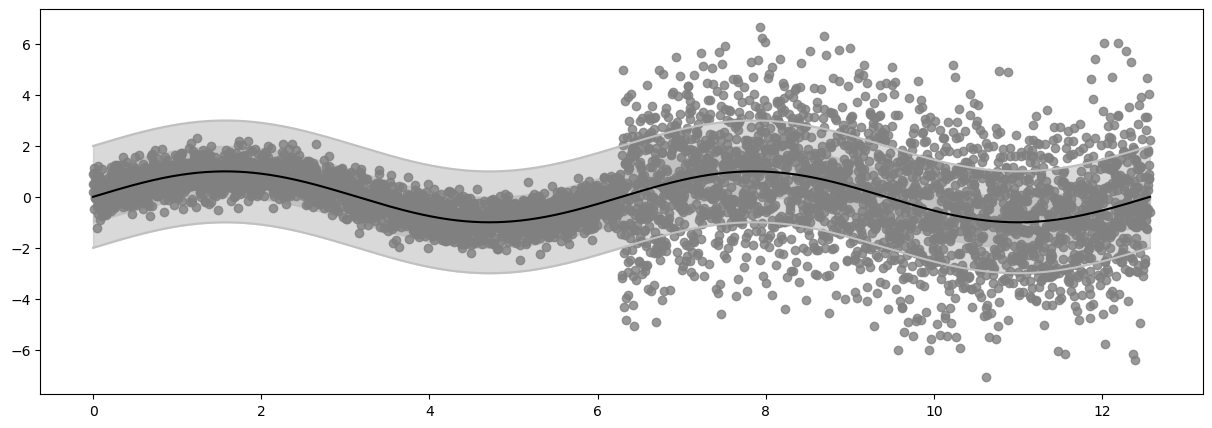

In [3]:
def plot_distribution(X, Y, loc, scale):
    plt.figure(figsize=(15, 5))
    x = X.squeeze()
    for k in (1, 2):
        lb = (loc - k * scale).squeeze()
        ub = (loc + k * scale).squeeze()
        plt.fill_between(x, lb, ub, color="silver", alpha=1 - 0.05 * k ** 3)
    plt.plot(x, lb, color="silver")
    plt.plot(x, ub, color="silver")
    plt.plot(X, loc, color="black")
    plt.scatter(X, Y, color="gray", alpha=0.8)


plot_distribution(X, Y, loc, 1)

### Model
Likelihood expects a MOGP location and scale, and maps these to a single likelihood. 

In [4]:
likelihood = gpf.likelihoods.HeteroskedasticTFPConditional(
    distribution_class=tfp.distributions.Normal,  # Gaussian Likelihood
    scale_transform=tfp.bijectors.Exp(),  # Exponential Transform
)

print(f"Likelihood's expected latent_dim: {likelihood.latent_dim}")



Likelihood's expected latent_dim: 2


Model the mean with a regular RBF kernel, and the variance with a changepoint kernel, via a multi-output kernel. Since the scale is now also a GP, we can just insert the CP kernel there:

In [5]:

kernel = gpf.kernels.SeparateIndependent(
    [
        gpf.kernels.SquaredExponential(),  # This is k1, the kernel of f1
        gpf.kernels.ChangePoints([gpf.kernels.Constant() for i in range(2)], locations=[np.random.choice(X.flatten())], steepness=[1]),  # this is k2, the kernel of f2
    ]
)
# The number of kernels contained in gpf.kernels.SeparateIndependent must be the same as likelihood.latent_dim


From here on out the optimization is pretty standard:

In [6]:
M = 20  # Number of inducing variables for each f_i

# Initial inducing points position Z
Z = np.linspace(X.min(), X.max(), M)[:, None]  # Z must be of shape [M, 1]

inducing_variable = gpf.inducing_variables.SeparateIndependentInducingVariables(
    [
        gpf.inducing_variables.InducingPoints(Z),  # This is U1 = f1(Z1)
        gpf.inducing_variables.InducingPoints(Z),  # This is U2 = f2(Z2)
    ]
)


In [7]:
model = gpf.models.SVGP(
    kernel=kernel,
    likelihood=likelihood,
    inducing_variable=inducing_variable,
    num_latent_gps=likelihood.latent_dim,
)

model



<gpflow.models.svgp.SVGP object at 0x7fad8b1bead0>
╒════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════╤═════════╤══════════════════╕
│ name                                               │ class     │ transform      │ prior   │ trainable   │ shape       │ dtype   │ value            │
╞════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════╪═════════╪══════════════════╡
│ SVGP.kernel.kernels[0].variance                    │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.0              │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────┤
│ SVGP.kernel.kernels[0].lengthscales                │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.0              │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────┤
│ SVGP.kernel.kernels[1].kernels[0].variance         │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.0              │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────┤
│ SVGP.kernel.kernels[1].kernels[1].variance         │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.0              │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────┤
│ SVGP.kernel.kernels[1].locations                   │ Parameter │ Identity       │         │ True        │ (1,)        │ float64 │ [4.0137]         │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────┤
│ SVGP.kernel.kernels[1].steepness                   │ Parameter │ Softplus       │         │ True        │ (1,)        │ float64 │ [1.]             │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────┤
│ SVGP.inducing_variable.inducing_variable_list[0].Z │ Parameter │ Identity       │         │ True        │ (20, 1)     │ float64 │ [[0....          │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────┤
│ SVGP.inducing_variable.inducing_variable_list[1].Z │ Parameter │ Identity       │         │ True        │ (20, 1)     │ float64 │ [[0....          │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────┤
│ SVGP.q_mu                                          │ Parameter │ Identity       │         │ True        │ (20, 2)     │ float64 │ [[0., 0....      │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────┤
│ SVGP.q_sqrt                                        │ Parameter │ FillTriangular │         │ True        │ (2, 20, 20) │ float64 │ [[[1., 0., 0.... │
╘════════════════════════════════════════════════════╧═══════════╧════════════════╧═════════╧═════════════╧═════════════╧═════════╧══════════════════╛

In [8]:
data = (X, Y)
loss_fn = model.training_loss_closure(data)

gpf.utilities.set_trainable(model.q_mu, False)
gpf.utilities.set_trainable(model.q_sqrt, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpf.optimizers.NaturalGradient(gamma=0.1)

adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)


@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

In [9]:
data = (X, Y)
loss_fn = model.training_loss_closure(data)

gpf.utilities.set_trainable(model.q_mu, False)
gpf.utilities.set_trainable(model.q_sqrt, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpf.optimizers.NaturalGradient(gamma=0.1)

adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)


@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

Instructions for updating:
Use fn_output_signature instead
Epoch 50 - Loss:  7502.6442


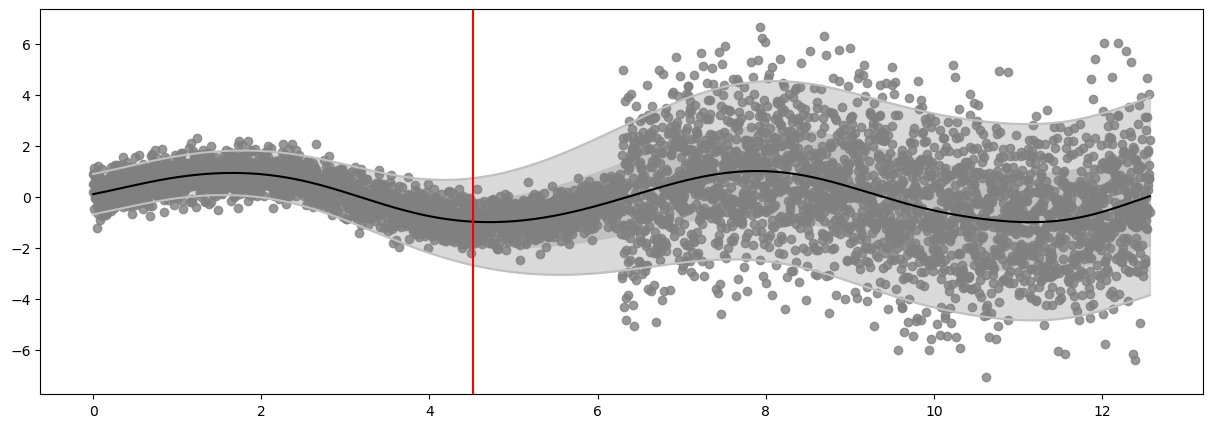

Epoch 100 - Loss:  7422.2913


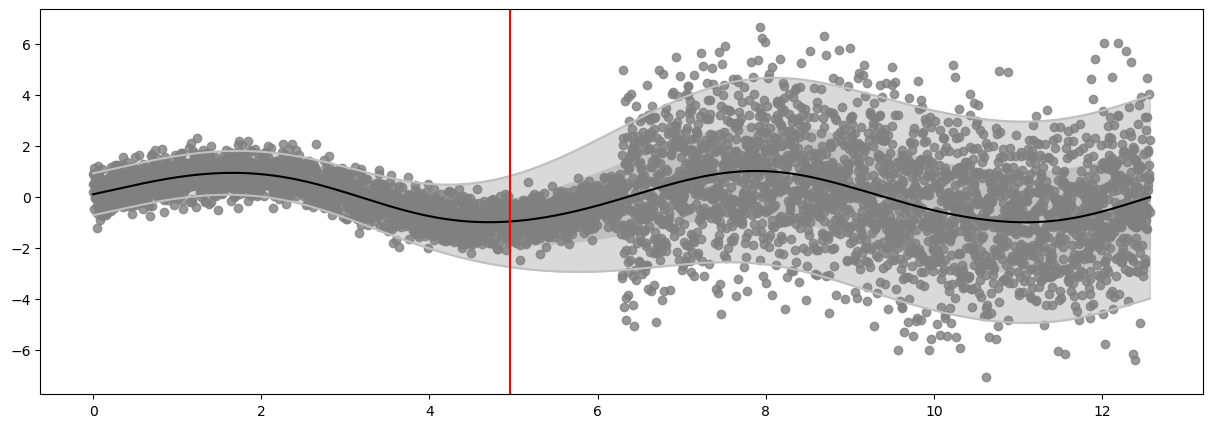

Epoch 150 - Loss:  7320.7794


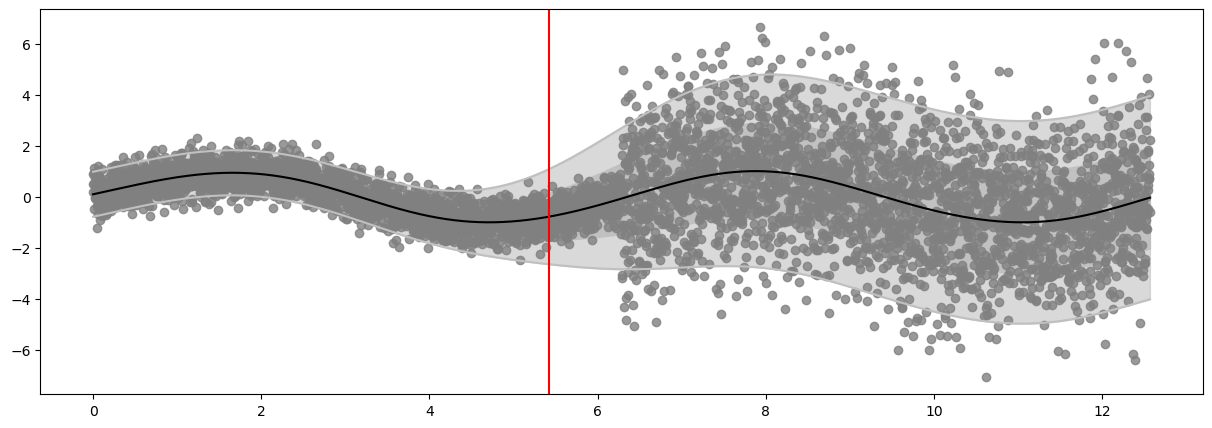

Epoch 200 - Loss:  7237.3389


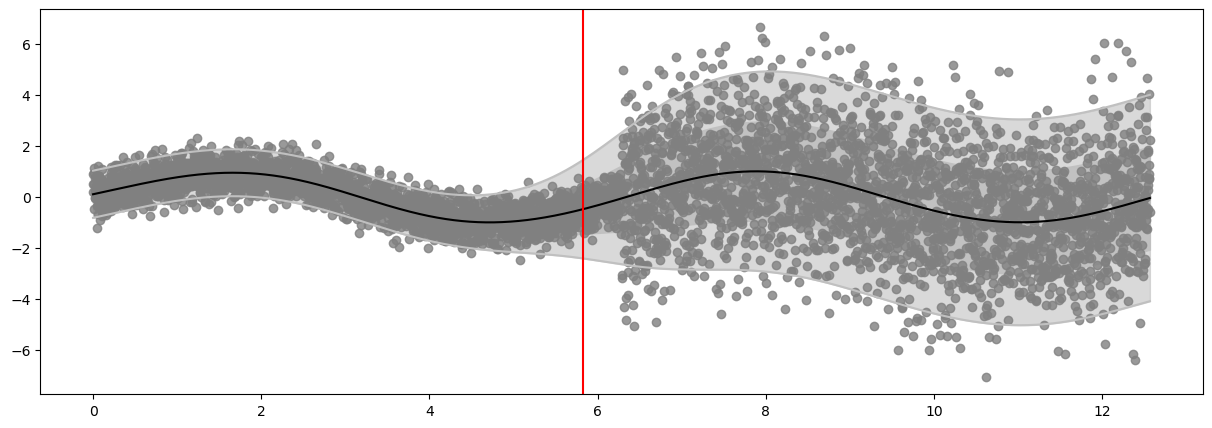

Epoch 250 - Loss:  7196.7829


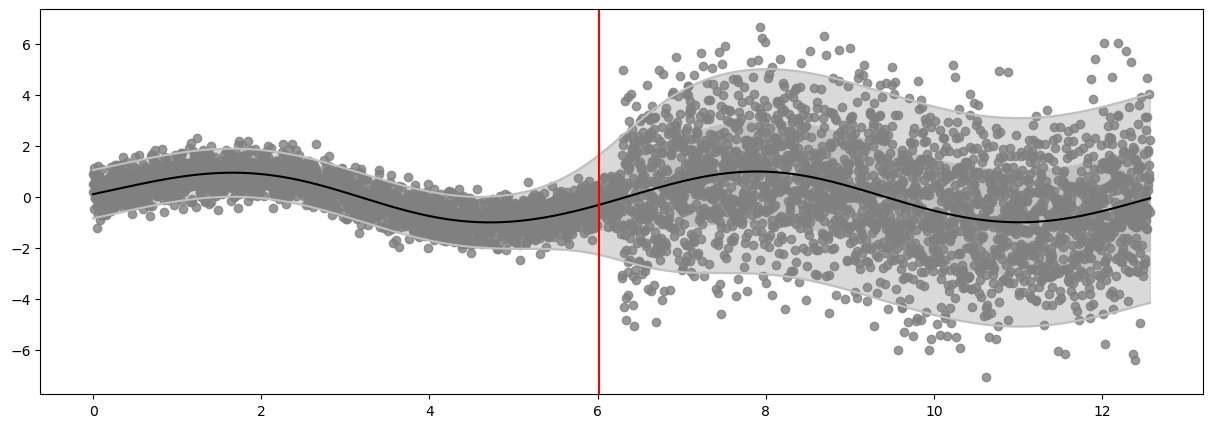

Epoch 300 - Loss:  7176.8639


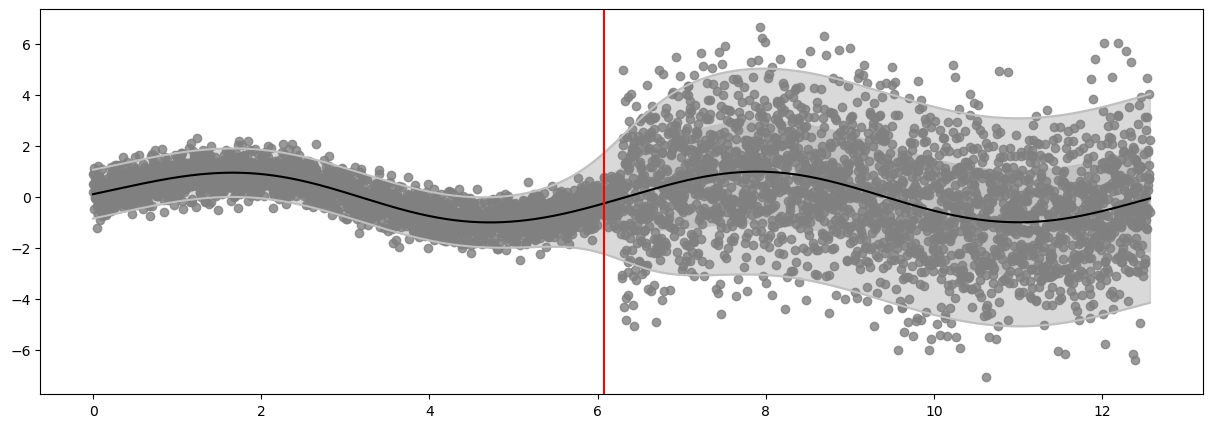

Epoch 350 - Loss:  7164.0158


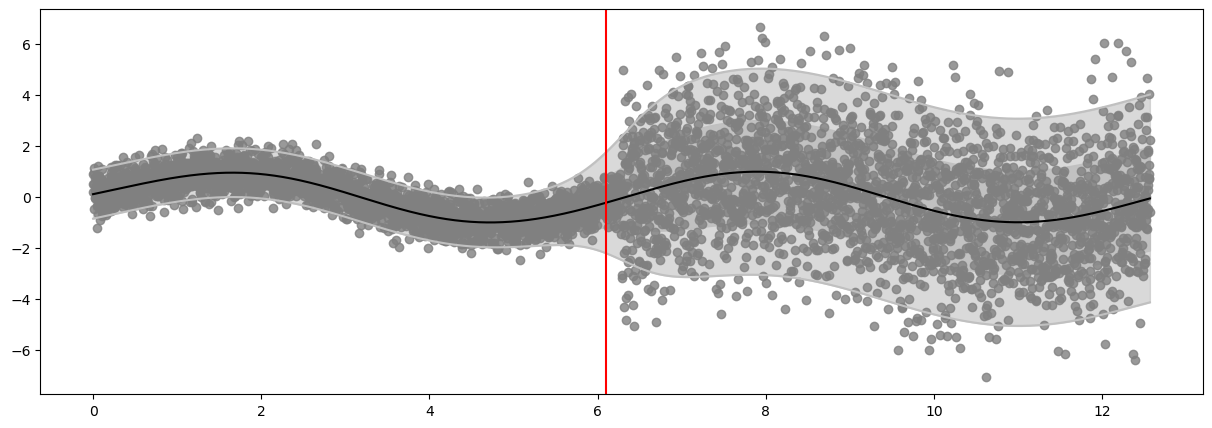

Epoch 400 - Loss:  7154.4957


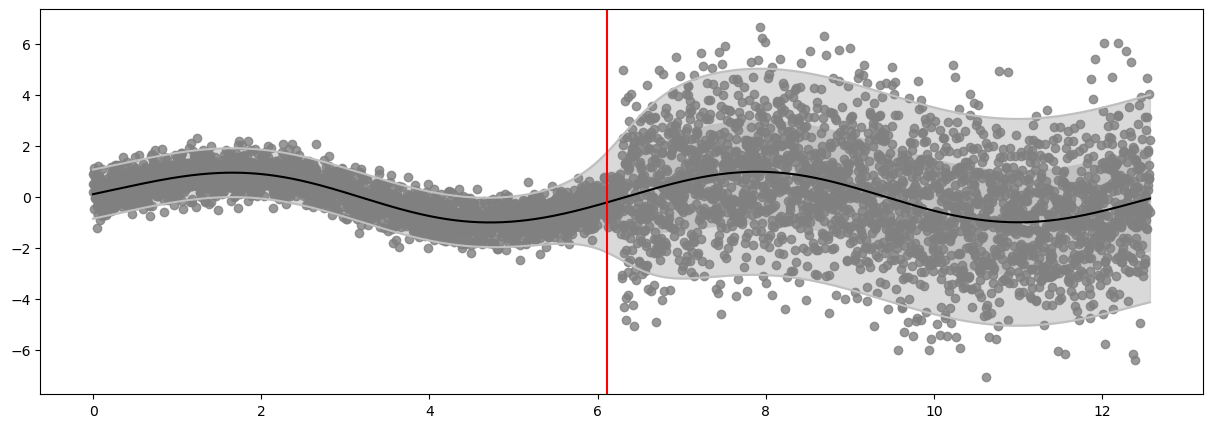

Epoch 450 - Loss:  7147.1426


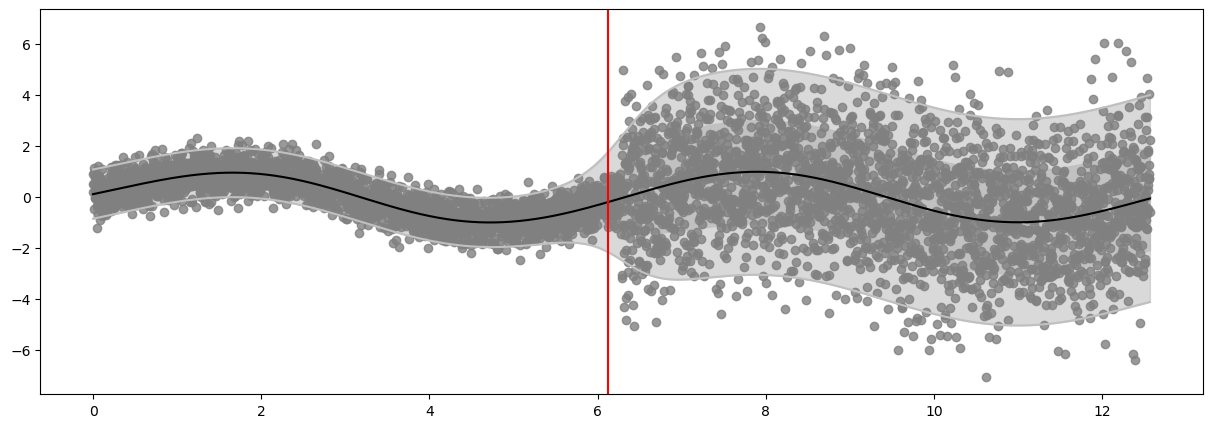

<gpflow.models.svgp.SVGP object at 0x7fad8b1bead0>
╒════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════╤═════════╤══════════════════════════════════════════╕
│ name                                               │ class     │ transform      │ prior   │ trainable   │ shape       │ dtype   │ value                                    │
╞════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════╪═════════╪══════════════════════════════════════════╡
│ SVGP.kernel.kernels[0].variance                    │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.34677                                  │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ SVGP.kernel.kernels[0].lengthscales                │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.79886                                  │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ SVGP.kernel.kernels[1].kernels[0].variance         │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 0.85953                                  │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ SVGP.kernel.kernels[1].kernels[1].variance         │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.53418                                  │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ SVGP.kernel.kernels[1].locations                   │ Parameter │ Identity       │         │ True        │ (1,)        │ float64 │ [6.13598]                                │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ SVGP.kernel.kernels[1].steepness                   │ Parameter │ Softplus       │         │ True        │ (1,)        │ float64 │ [4.0826]                                 │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ SVGP.inducing_variable.inducing_variable_list[0].Z │ Parameter │ Identity       │         │ True        │ (20, 1)     │ float64 │ [[-2.381800e-01...                       │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ SVGP.inducing_variable.inducing_variable_list[1].Z │ Parameter │ Identity       │         │ True        │ (20, 1)     │ float64 │ [[-0.44024...                            │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ SVGP.q_mu                                          │ Parameter │ Identity       │         │ False       │ (20, 2)     │ float64 │ [[-4.4190e-02, -7.8952e-01...            │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ SVGP.q_sqrt                                        │ Parameter │ FillTriangular │         │ False       │ (2, 20, 20) │ float64 │ [[[7.7440e-02, 0.0000e+00, 0.0000e+00... │
╘════════════════════════════════════════════════════╧═══════════╧════════════════╧═════════╧══════

In [10]:
epochs = 1000
log_freq = 50
prev = np.inf
for epoch in range(1, epochs + 1):
    optimisation_step()
    if prev - loss_fn().numpy() < 0.0001:
        break
    prev = loss_fn().numpy()
    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        Ymean, Yvar = model.predict_y(X)
        Ymean = Ymean.numpy().squeeze()
        Ystd = tf.sqrt(Yvar).numpy().squeeze()
        plot_distribution(X, Y, Ymean, Ystd)
        plt.axvline(model.kernel.kernels[1].locations.numpy(), color="r")
        plt.show()

model

Epoch 50 - Loss:  9304.0890
Epoch 100 - Loss:  9102.3695
Epoch 150 - Loss:  9025.6784
Epoch 200 - Loss:  8993.9800
Epoch 250 - Loss:  8980.3891
Epoch 300 - Loss:  8974.4889
Epoch 350 - Loss:  8971.9116
Epoch 400 - Loss:  8970.7606
Epoch 450 - Loss:  8970.2098
Epoch 500 - Loss:  8969.9069
Epoch 550 - Loss:  8969.7072
Epoch 600 - Loss:  8969.5543
Epoch 650 - Loss:  8969.4269
Epoch 700 - Loss:  8969.3165
Epoch 750 - Loss:  8969.2195
Epoch 800 - Loss:  8969.1335
Epoch 850 - Loss:  8969.0572
Epoch 900 - Loss:  8968.9887
Epoch 950 - Loss:  8968.9272
Epoch 1000 - Loss:  8968.8716


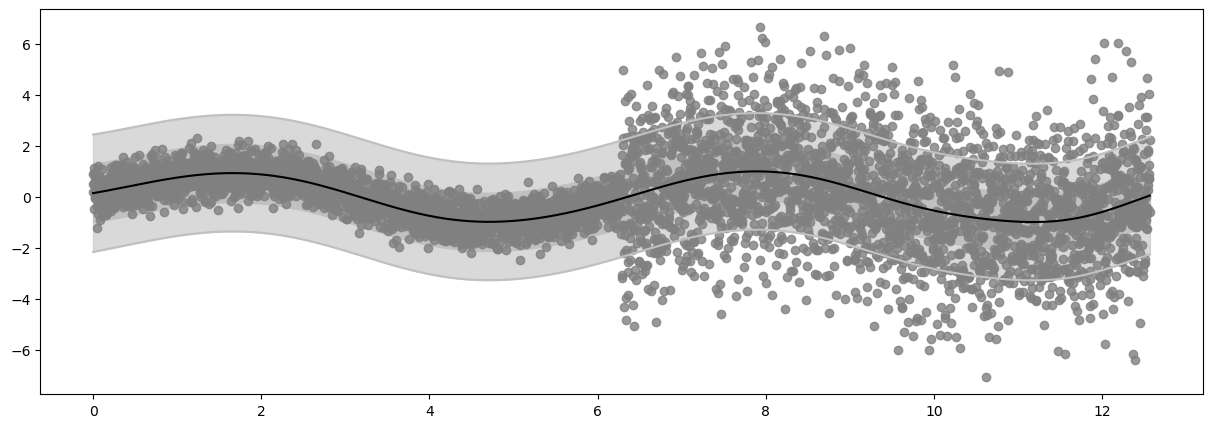

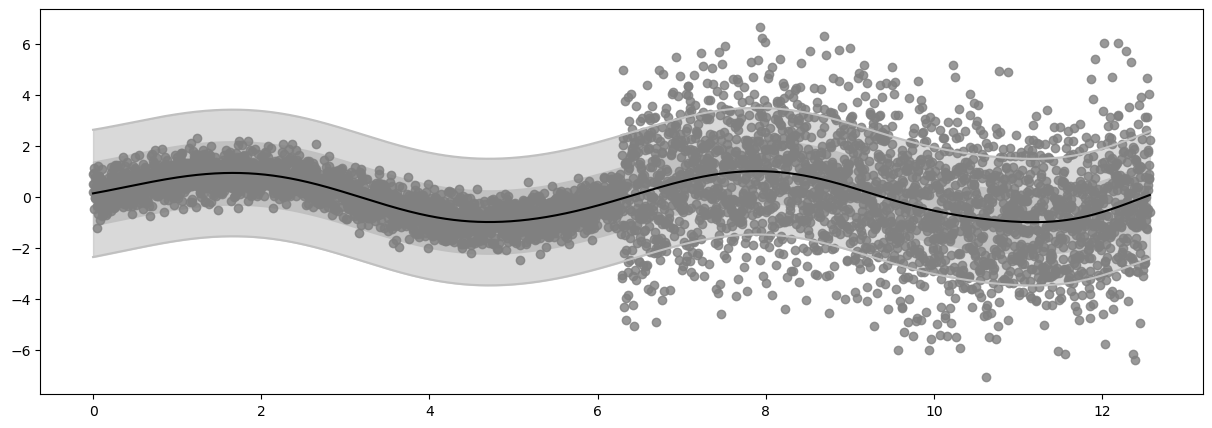

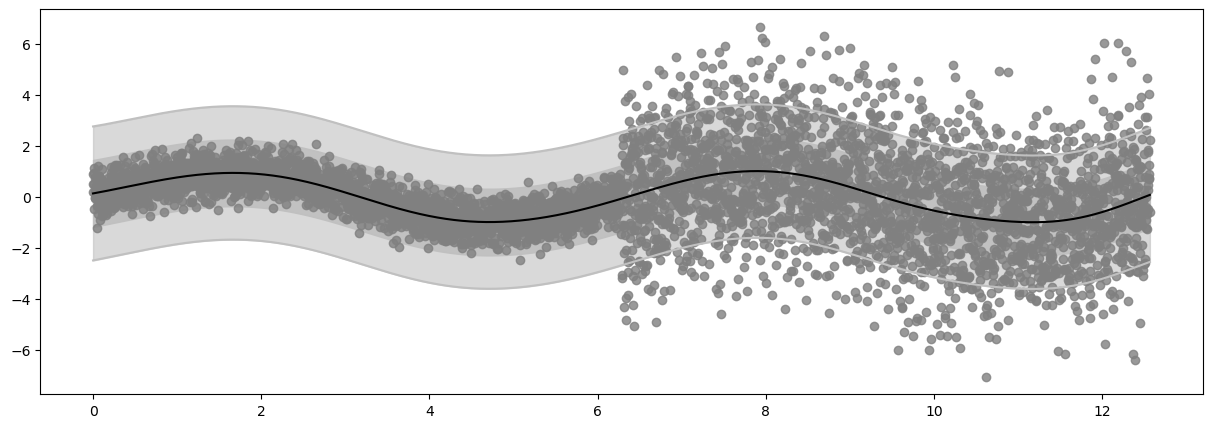

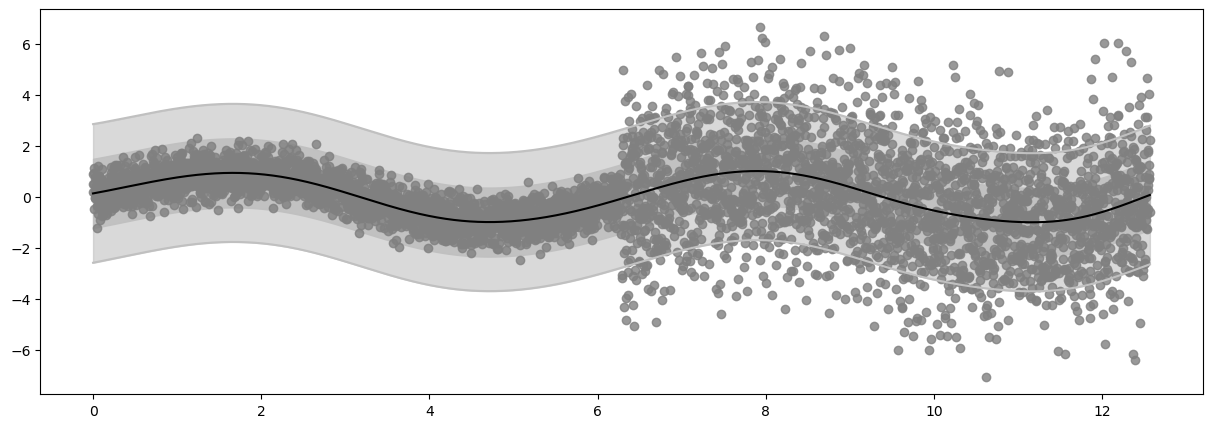

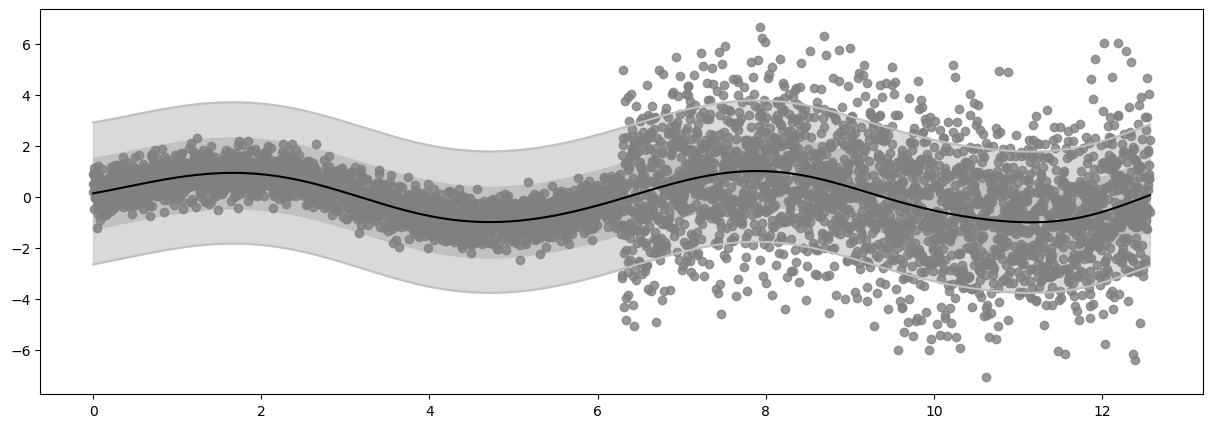

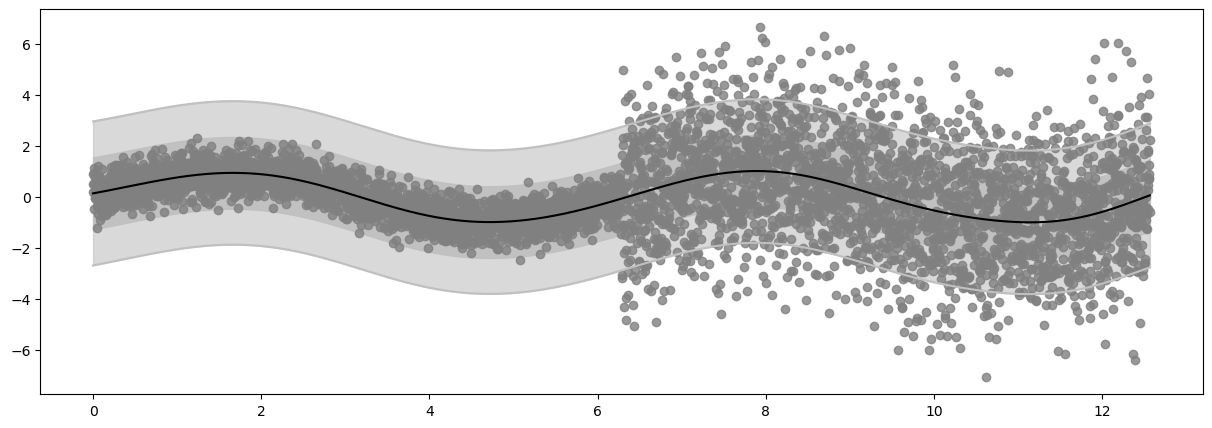

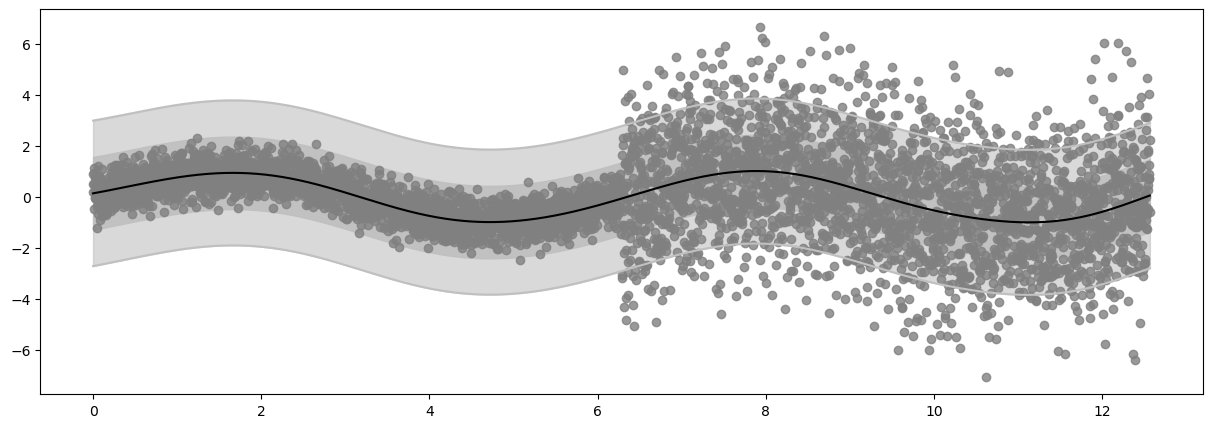

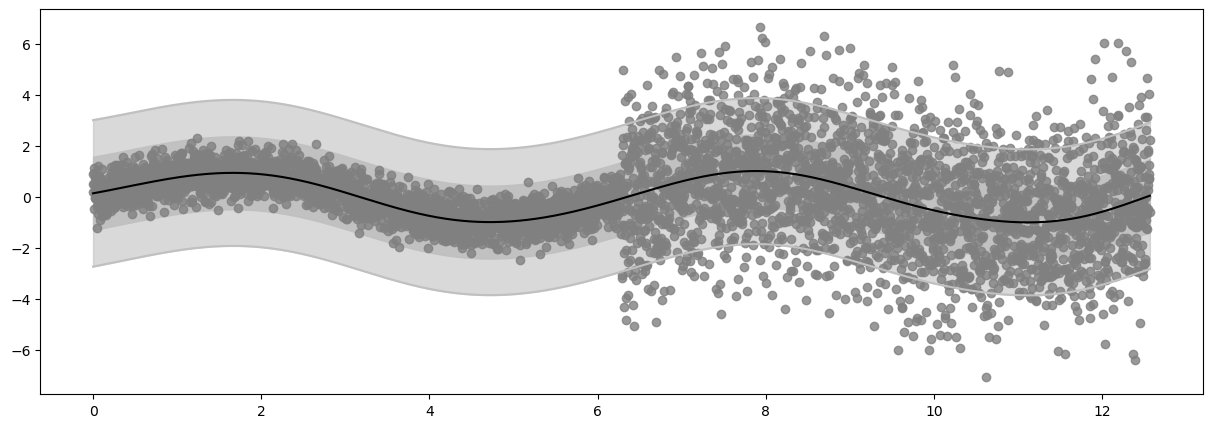

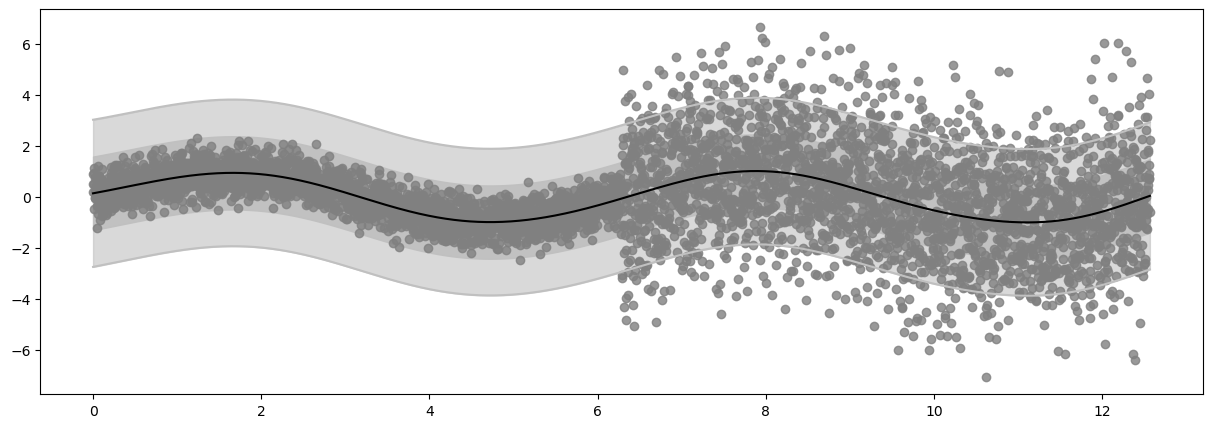

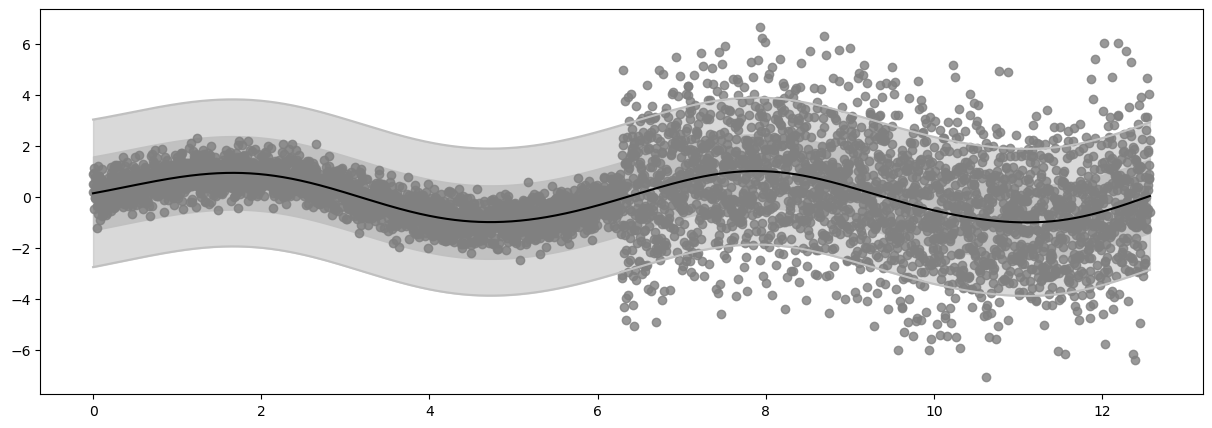

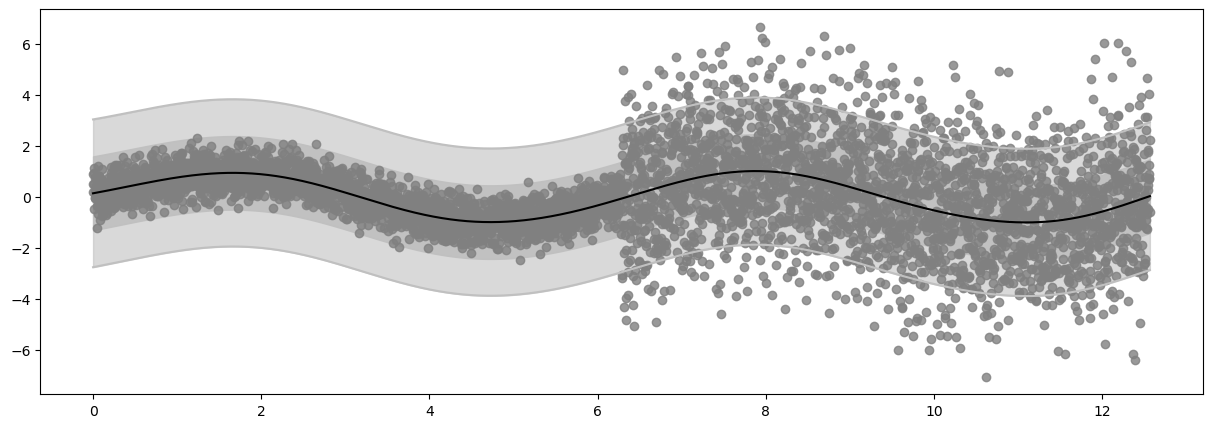

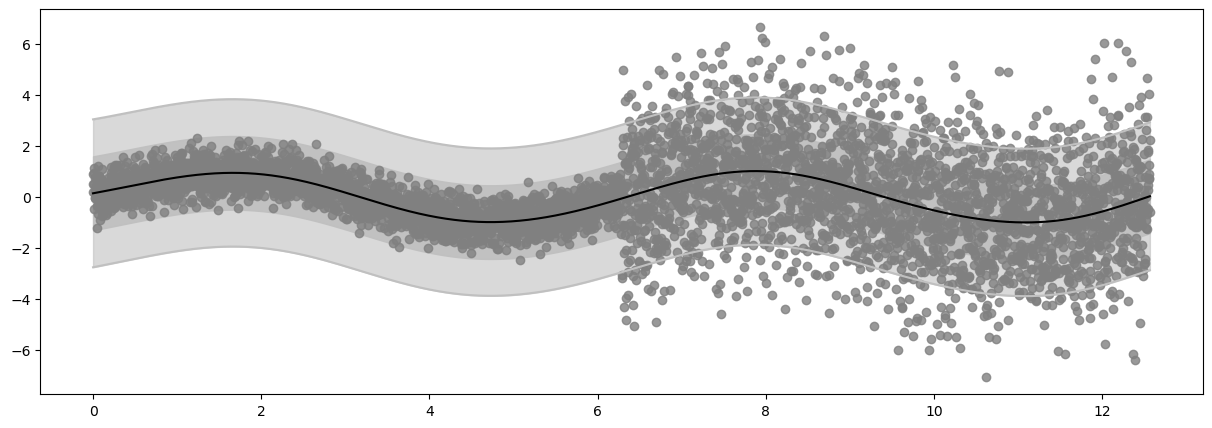

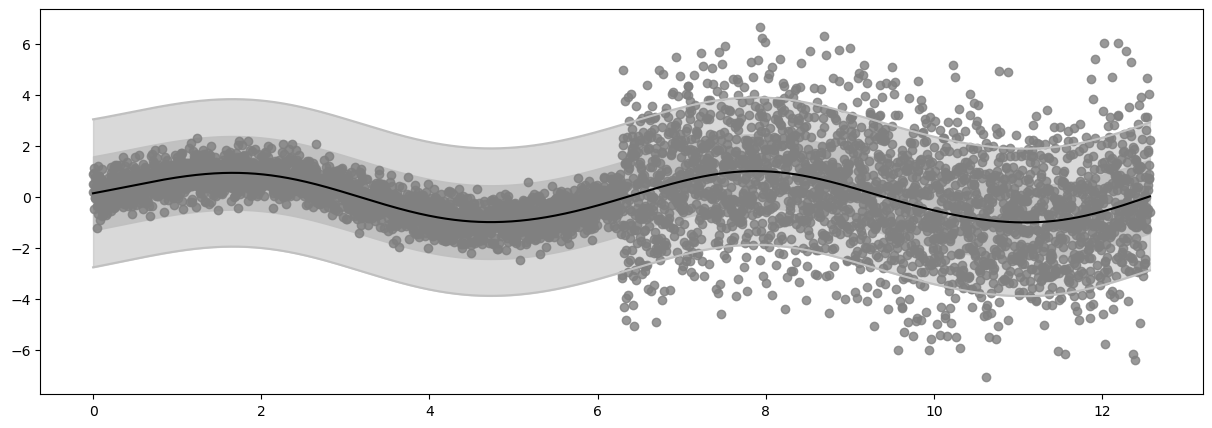

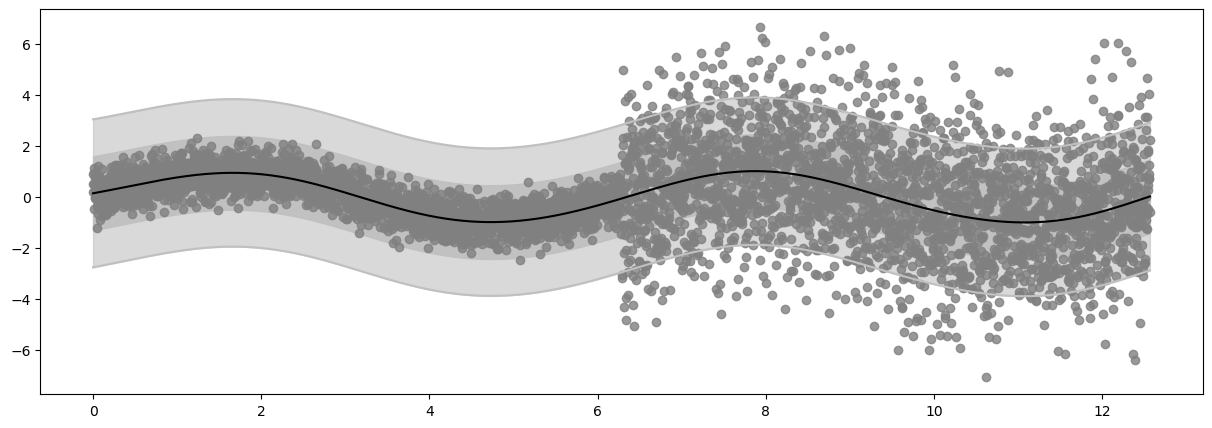

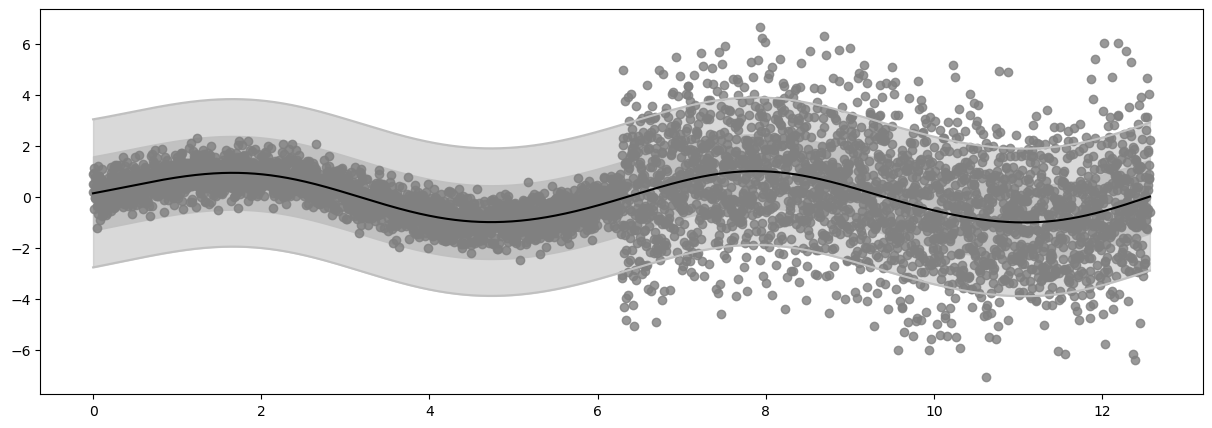

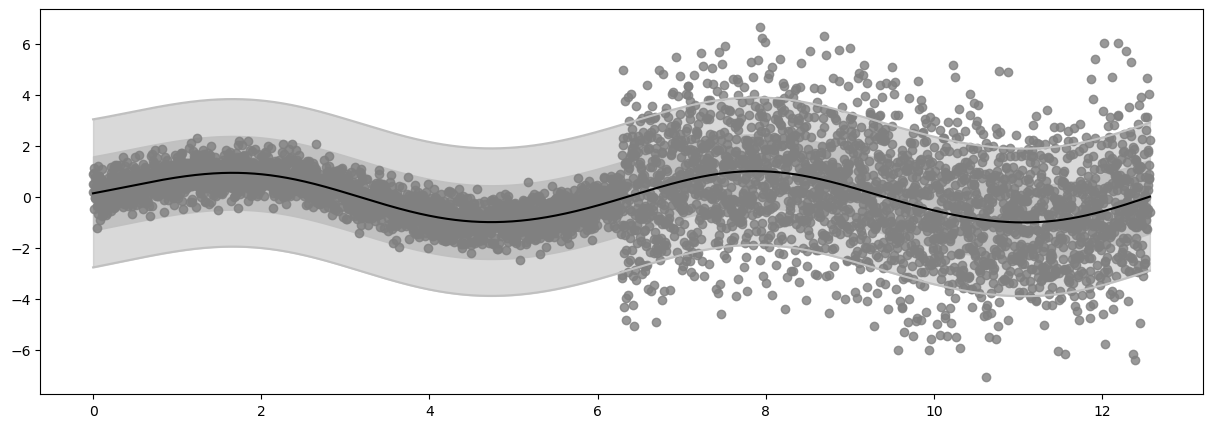

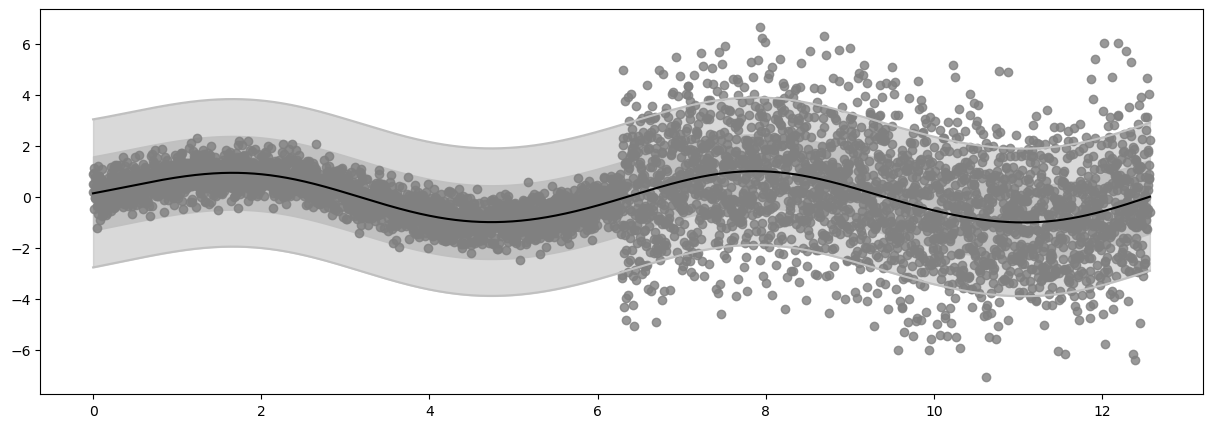

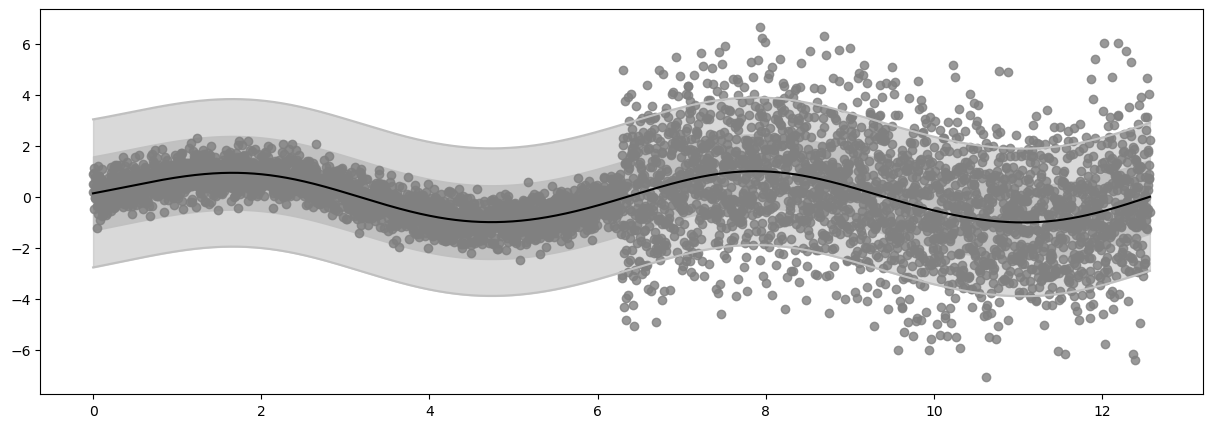

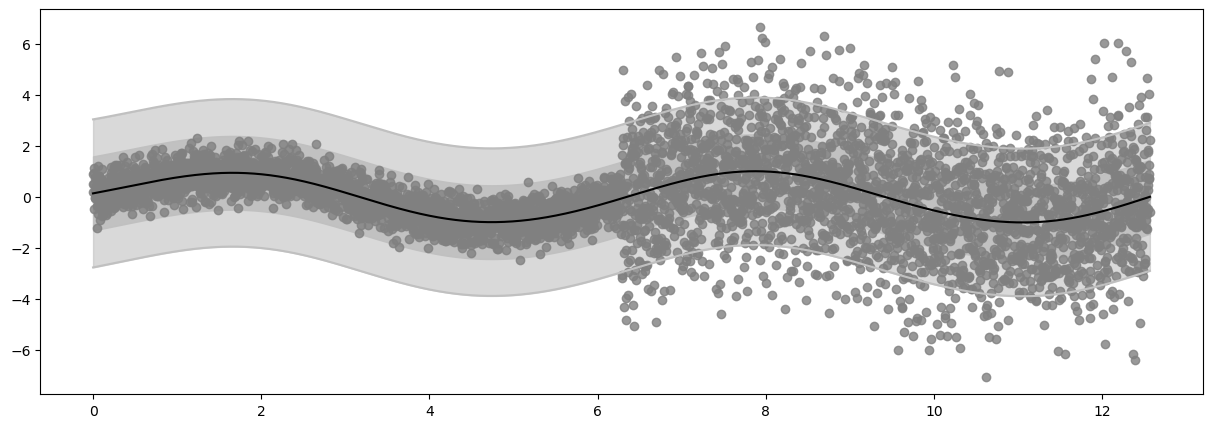

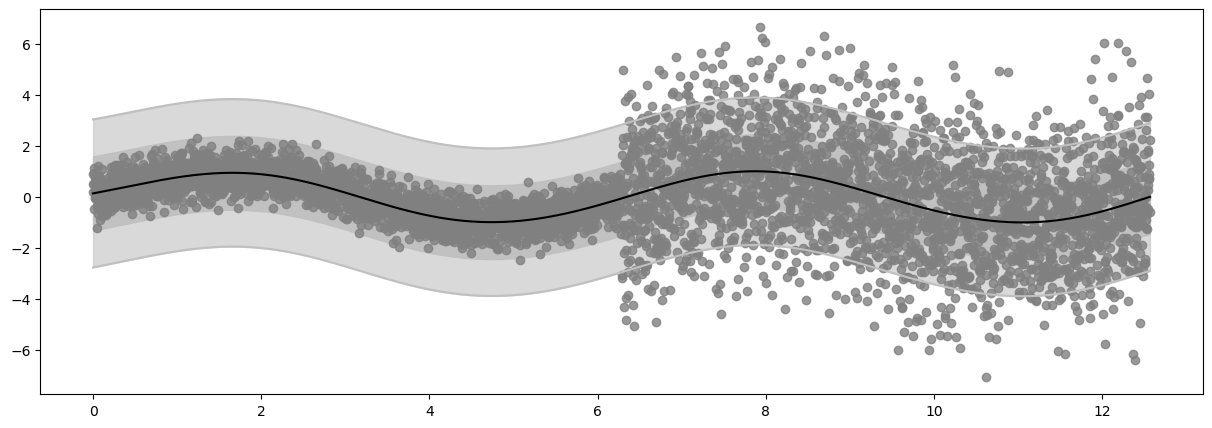

In [11]:
vanilla = gpf.models.SVGP(gpf.kernels.RBF(), likelihood=gpf.likelihoods.Gaussian(), inducing_variable=Z)

data = (X, Y)
loss_fn = vanilla.training_loss_closure(data)

gpf.utilities.set_trainable(vanilla.q_mu, False)
gpf.utilities.set_trainable(vanilla.q_sqrt, False)

variational_vars = [(vanilla.q_mu, vanilla.q_sqrt)]
natgrad_opt = gpf.optimizers.NaturalGradient(gamma=0.01)

adam_vars = vanilla.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)


@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)
    
for epoch in range(1, epochs + 1):
    optimisation_step()

    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        Ymean, Yvar = vanilla.predict_y(X)
        Ymean = Ymean.numpy().squeeze()
        Ystd = tf.sqrt(Yvar).numpy().squeeze()
        plot_distribution(X, Y, Ymean, Ystd)

In [12]:
from scipy.stats import chi2
lrt = -2 * (vanilla.elbo(data) - model.elbo(data))
print(lrt)
print(len(model.trainable_variables), len(vanilla.trainable_variables))
chi2.sf(lrt, 4)  # Usually the CP model performs better

tf.Tensor(3653.1827775373313, shape=(), dtype=float64)
8 4


0.0

1115209
2013-04-23 09:46:00
-3435


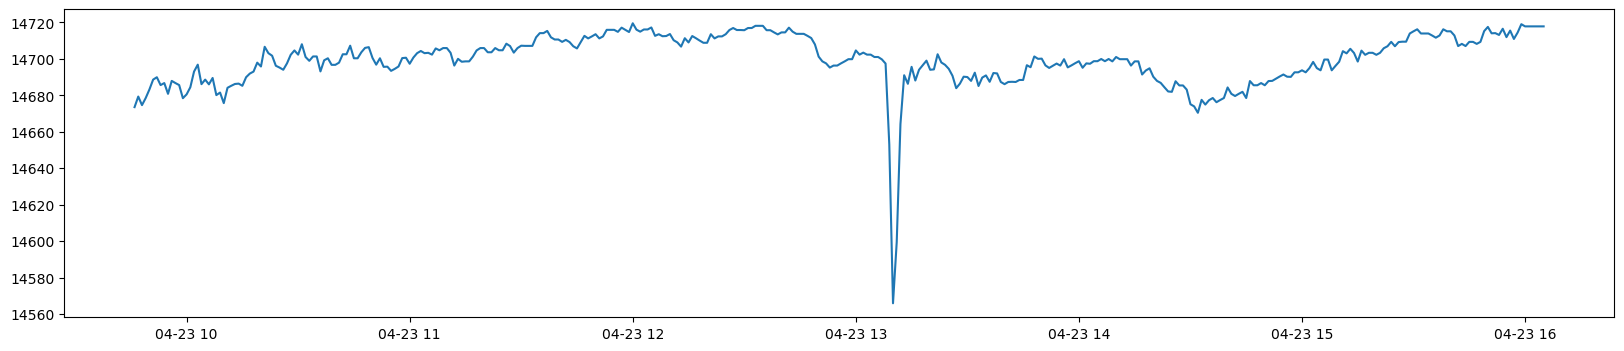

In [48]:
import kagglehub
import pandas as pd

df = pd.read_csv("/home/janneke/robust-cpgp/RCGP/experiments/data/Flashcrash/DJI.txt").dropna()
print(len(df))
df.columns = [0, 1, 2, 3, 4]
y = df[1].to_numpy().reshape(-1, 1)[434100:434480]
X = np.arange(len(y)).reshape(-1, 1).astype(float)[434100:434480]
date = pd.to_datetime(df[0])[434100:434480]
print(date.iloc[0])
plt.figure(figsize=(20, 4))
plt.plot(date, y)
print(465-650*6)

In [14]:
likelihood = gpf.likelihoods.HeteroskedasticTFPConditional(
    distribution_class=tfp.distributions.Normal,  # Gaussian Likelihood
    scale_transform=tfp.bijectors.Exp(),  # Exponential Transform
)

print(f"Likelihood's expected latent_dim: {likelihood.latent_dim}")

kernel = gpf.kernels.SeparateIndependent(
    [
        gpf.kernels.Constant(),  # this is k2, the kernel of f2
        gpf.kernels.ChangePoints([gpf.kernels.Constant() for i in range(2)], locations=[np.random.choice(X.flatten()) for i in range(1)], steepness=[0.1 for i in range(1)]),  # this is k2, the kernel of f2
    ]
)
# The number of kernels contained in gpf.kernels.SeparateIndependent must be the same as likelihood.latent_dim

M = 20  # Number of inducing variables for each f_i

# Initial inducing points position Z
Z = np.linspace(X.min(), X.max(), M)[:, None]  # Z must be of shape [M, 1]

inducing_variable = gpf.inducing_variables.SeparateIndependentInducingVariables(
    [
        gpf.inducing_variables.InducingPoints(Z),  # This is U1 = f1(Z1)
        gpf.inducing_variables.InducingPoints(Z),  # This is U2 = f2(Z2)
    ]
)

Likelihood's expected latent_dim: 2


ValueError: 'a' cannot be empty unless no samples are taken

In [ ]:
model = gpf.models.SVGP(
    kernel=kernel,
    likelihood=likelihood,
    inducing_variable=inducing_variable,
    num_latent_gps=likelihood.latent_dim,
)

model

<gpflow.models.svgp.SVGP object at 0x7ff719633a10>
╒════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════╤═════════╤══════════════════╕
│ name                                               │ class     │ transform      │ prior   │ trainable   │ shape       │ dtype   │ value            │
╞════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════╪═════════╪══════════════════╡
│ SVGP.kernel.kernels[0].variance                    │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.0              │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────┤
│ SVGP.kernel.kernels[1].kernels[0].variance         │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.0              │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────┤
│ SVGP.kernel.kernels[1].kernels[1].variance         │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.0              │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────┤
│ SVGP.kernel.kernels[1].locations                   │ Parameter │ Identity       │         │ True        │ (1,)        │ float64 │ [755.]           │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────┤
│ SVGP.kernel.kernels[1].steepness                   │ Parameter │ Softplus       │         │ True        │ (1,)        │ float64 │ [0.1]            │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────┤
│ SVGP.inducing_variable.inducing_variable_list[0].Z │ Parameter │ Identity       │         │ True        │ (20, 1)     │ float64 │ [[0....          │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────┤
│ SVGP.inducing_variable.inducing_variable_list[1].Z │ Parameter │ Identity       │         │ True        │ (20, 1)     │ float64 │ [[0....          │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────┤
│ SVGP.q_mu                                          │ Parameter │ Identity       │         │ True        │ (20, 2)     │ float64 │ [[0., 0....      │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────┤
│ SVGP.q_sqrt                                        │ Parameter │ FillTriangular │         │ True        │ (2, 20, 20) │ float64 │ [[[1., 0., 0.... │
╘════════════════════════════════════════════════════╧═══════════╧════════════════╧═════════╧═════════════╧═════════════╧═════════╧══════════════════╛

In [ ]:
data = (X, y)
loss_fn = model.training_loss_closure(data)

gpf.utilities.set_trainable(model.q_mu, False)
gpf.utilities.set_trainable(model.q_sqrt, False)

variational_vars = [(model.q_mu, model.q_sqrt)]
natgrad_opt = gpf.optimizers.NaturalGradient(gamma=0.1)

adam_vars = model.trainable_variables
adam_opt = tf.optimizers.Adam(0.01)


@tf.function
def optimisation_step():
    natgrad_opt.minimize(loss_fn, variational_vars)
    adam_opt.minimize(loss_fn, adam_vars)

Epoch 500 - Loss: -4117.8717


/tmp/ipykernel_412614/2894276100.py:16: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  plt.axvline(date[int(model.kernel.kernels[1].locations.numpy())])


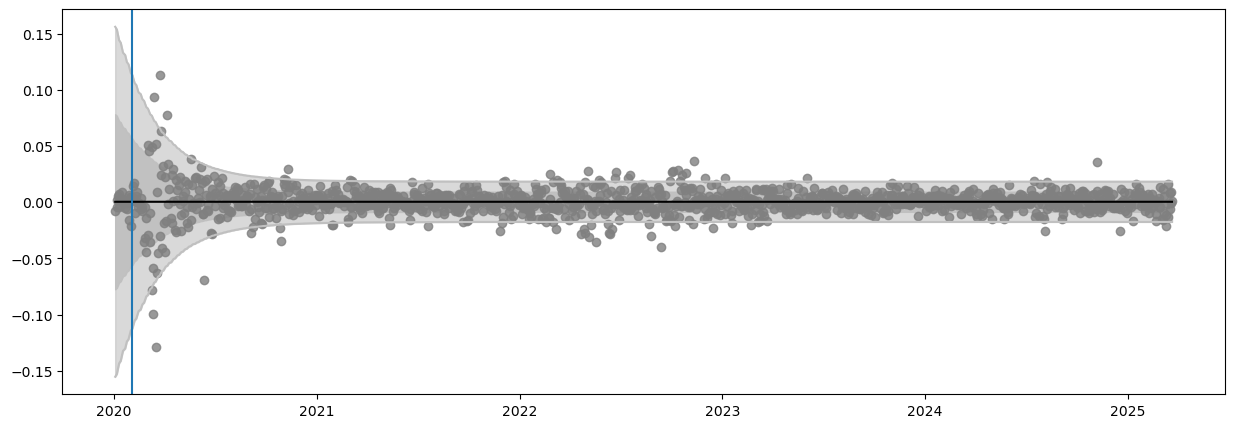

Epoch 1000 - Loss: -4120.7613


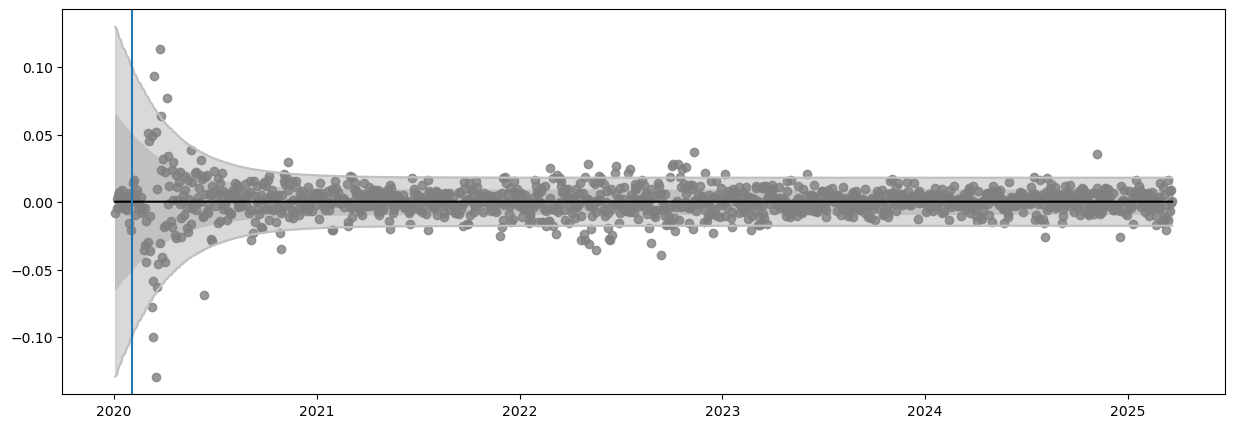

Epoch 1500 - Loss: -4122.6852


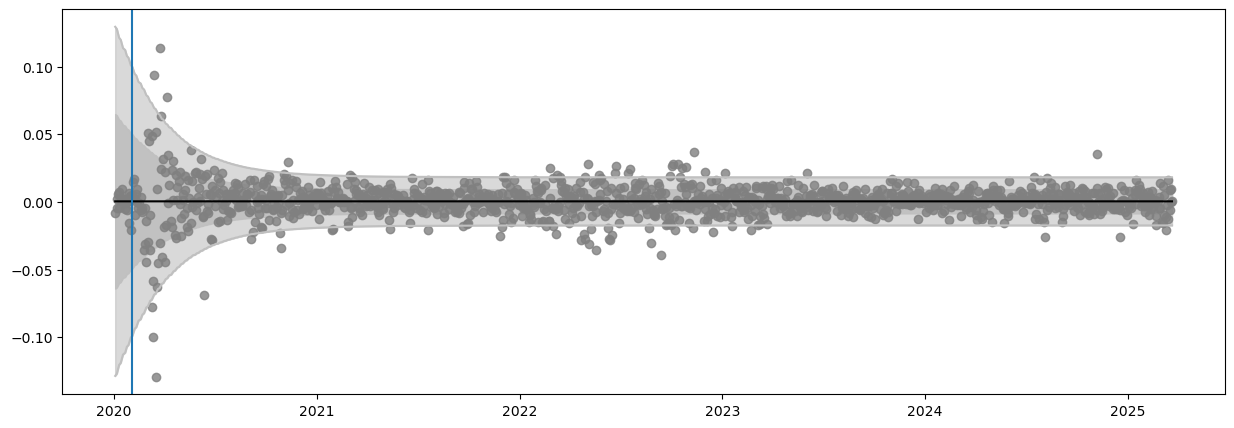

Epoch 2000 - Loss: -4124.7677


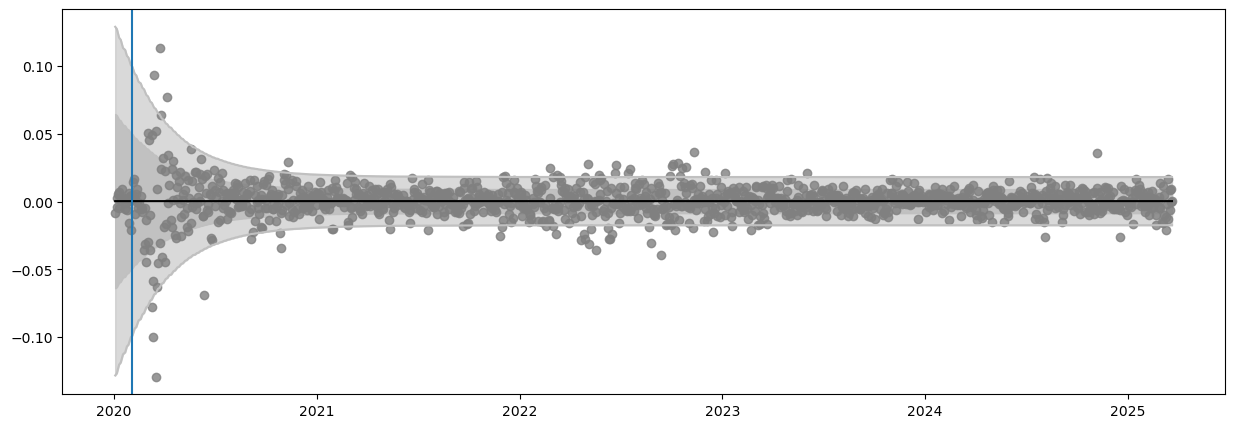

<gpflow.models.svgp.SVGP object at 0x7ff72828c950>
╒════════════════════════════════════════════════════╤═══════════╤════════════════╤═════════╤═════════════╤═════════════╤═════════╤══════════════════════════════════════════╕
│ name                                               │ class     │ transform      │ prior   │ trainable   │ shape       │ dtype   │ value                                    │
╞════════════════════════════════════════════════════╪═══════════╪════════════════╪═════════╪═════════════╪═════════════╪═════════╪══════════════════════════════════════════╡
│ SVGP.kernel.kernels[0].variance                    │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1e-05                                    │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ SVGP.kernel.kernels[1].kernels[0].variance         │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.92995                                  │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ SVGP.kernel.kernels[1].kernels[1].variance         │ Parameter │ Softplus       │         │ True        │ ()          │ float64 │ 1.40731                                  │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ SVGP.kernel.kernels[1].locations                   │ Parameter │ Identity       │         │ True        │ (1,)        │ float64 │ [21.53887]                               │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ SVGP.kernel.kernels[1].steepness                   │ Parameter │ Softplus       │         │ True        │ (1,)        │ float64 │ [0.0154]                                 │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ SVGP.inducing_variable.inducing_variable_list[0].Z │ Parameter │ Identity       │         │ True        │ (20, 1)     │ float64 │ [[0....                                  │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ SVGP.inducing_variable.inducing_variable_list[1].Z │ Parameter │ Identity       │         │ True        │ (20, 1)     │ float64 │ [[-5.12020000e-01...                     │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ SVGP.q_mu                                          │ Parameter │ Identity       │         │ False       │ (20, 2)     │ float64 │ [[1.32430e-01, -2.89266e+00...           │
├────────────────────────────────────────────────────┼───────────┼────────────────┼─────────┼─────────────┼─────────────┼─────────┼──────────────────────────────────────────┤
│ SVGP.q_sqrt                                        │ Parameter │ FillTriangular │         │ False       │ (2, 20, 20) │ float64 │ [[[3.3090e-01, 0.0000e+00, 0.0000e+00... │
╘════════════════════════════════════════════════════╧═══════════╧════════════════╧═════════╧═════════════╧═════════════╧═════════╧══════════════════════════════════════════╛

In [ ]:
epochs = 2000
log_freq = 500
prev = np.inf
for epoch in range(1, epochs + 1):
    optimisation_step()
    if prev - loss_fn().numpy() < 0.0001:
        break
    prev = loss_fn().numpy()
    # For every 'log_freq' epochs, print the epoch and plot the predictions against the data
    if epoch % log_freq == 0 and epoch > 0:
        print(f"Epoch {epoch} - Loss: {loss_fn().numpy() : .4f}")
        Ymean, Yvar = model.predict_y(X)
        Ymean = Ymean.numpy().squeeze()
        Ystd = tf.sqrt(Yvar).numpy().squeeze()
        plot_distribution(date, y, Ymean, Ystd)
        plt.axvline(date[int(model.kernel.kernels[1].locations.numpy())])
        plt.show()

model

In [ ]:
date[int(model.kernel.kernels[1].locations.numpy())]

/tmp/ipykernel_412614/4230392252.py:1: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  date[int(model.kernel.kernels[1].locations.numpy())]


Timestamp('2020-02-03 00:00:00')